# dataset

> This module contains the dataset of the soundscapes and a function to retrieve it.

In [ ]:
#| default_exp dataset

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [ ]:
#| export
from IPython.display import Audio
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

from birdclef.utils import DATA_DIR, AUDIO_DATA_DIR, mel_to_wave, plot_audio, plot_spectrogram

## Pytorch dataset of soundscapes

### Extraction pipeline

Cose che abbiamo provato:
- power 2.0 e visto che funziona meglio con un power piÃ¹ alto

`<<<<<<< HEAD`

In [ ]:
#| export
# Define custom feature extraction pipeline.
#
# 1. Check for sample rate and resample
# 2. Waveform Augmenations
# 3. Convert to mel-scale
# 4. Mel Augmenations
# 5. Check for lenght and stretch shorter videos


class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        seconds = 5,
        sample_rate=32000,
        f_min = 50,
        f_max = 16000,
        n_fft=2048,
        n_mels=128,
        hop_length = 1024,
        power = 8.0
    ):
        super().__init__()

        self.n_fft = n_fft
        self.seconds = seconds
        self.c_length = seconds * sample_rate // hop_length + 1
        # self.c_length = c_length * 62.6 #626 sono 10 secondi
        self.sample_rate = sample_rate
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, f_min=f_min, f_max=f_max, power=power)
        self.amptodb = torchaudio.transforms.AmplitudeToDB()
        self.stretch = torchaudio.transforms.TimeStretch(hop_length=hop_length, n_freq=128)

        #Augmentations
        # self.maskingFreq =  torchaudio.transforms.FrequencyMasking(freq_mask_param=30)
        # self.maskingTime = torchaudio.transforms.TimeMasking(time_mask_param=30)
        # self.noiser = torchaudio.transforms.AddNoise()
        # self.pitchShift = torchaudio.transforms.PitchShift(resample_freq, 4)


    def forward(self, filename):
        # 0 Load the File
        waveform, sample_rate = torchaudio.load(filename, frame_offset=0, num_frames=self.seconds*self.sample_rate)
        
        # 1 Check for the sample rate and eventually resample to 32k
        if sample_rate != self.sample_rate:
           print("Wrong sample rate: resampling audio")
           resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
           waveform = resampler(waveform)
        
        threshold_linear = waveform.std()
        window_size = 2000
        # Pad the waveform to ensure the envelope has the same length
        padding = (window_size) // 2 
        padded_waveform = torch.nn.functional.pad(waveform.unsqueeze(0), (padding, padding), 'constant', value=0).squeeze(0)

        # Calculate the envelope using a moving average filter
        envelope = torch.nn.functional.avg_pool1d(padded_waveform.abs().unsqueeze(0), kernel_size=window_size, stride=1).squeeze(0)
        envelope = envelope[:, :waveform.shape[1]]
        print(envelope.shape)

        # Create a binary mask based on the energy and threshold
        gate_mask = envelope >= threshold_linear

        # Apply the gating mask to the waveform
        gated_waveform = waveform.clone()
        gated_waveform[~gate_mask] *= 0.1
        # 2 Filtering noise
        #db_waveform = self.amptodb(waveform)
        #filter_mask = waveform < 0.02

        #filtered_waveform = waveform.clone()
        #filtered_waveform[filter_mask] = 0  

        # 3 Convert to mel-scale
        mel = self.melspec(gated_waveform)
        mel = self.amptodb(mel)

        # 4 Rescale the data 0-1
        # mel_max = mel.max()
        # mel = mel / mel_max
        
        # 5 Check for the length and stretch it to 10s, it is a transformation used to regularize the length of the data
        if mel.shape[2] < self.c_length:
          print("Audio too short: stretching it.")
          replay_rate =  mel.shape[2]/self.c_length
          #print(f"replay rate {replay_rate}%")
          mel = self.stretch(mel, replay_rate)
          mel = mel[:,:,0:self.c_length]
          #print(f"stretched shape {stretched.shape}")

        return mel.float()
    
    def inverse_transform(self, mel):
        n_stft = self.n_fft // 2 + 1
        mel = mel.cpu()
        mel = mel[:,:,0:self.c_length]
        print(mel.shape)
        invers_transform = torchaudio.transforms.InverseMelScale(sample_rate=self.sample_rate, n_stft=n_stft)
        grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=self.n_fft)

        mel = torch.pow(10, mel/10)
        inverse_waveform = invers_transform(mel)
        pseudo_waveform = grifflim_transform(inverse_waveform)

        return pseudo_waveform

`=======`

`>>>>>>> '8b8e8d95375fbf2e8856d3b42597129d3f7fcf41'`

In [ ]:
pipeline = MyPipeline()
mel_spec = pipeline(AUDIO_DATA_DIR + 'abethr1/XC128013.ogg')
plot_spectrogram(mel_spec[0], title='Mel spectrogram', db=True)
waveform = mel_to_wave(mel_spec)
plot_audio(waveform=waveform, sample_rate=32000)
Audio(waveform.numpy(), rate=32000)



### Testing noisy audio


Original audio


torch.Size([1, 160000])


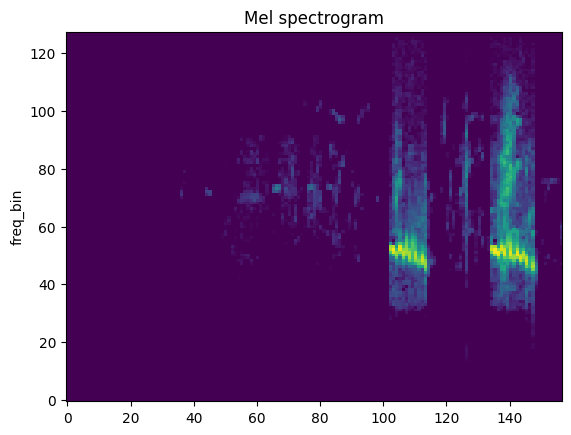

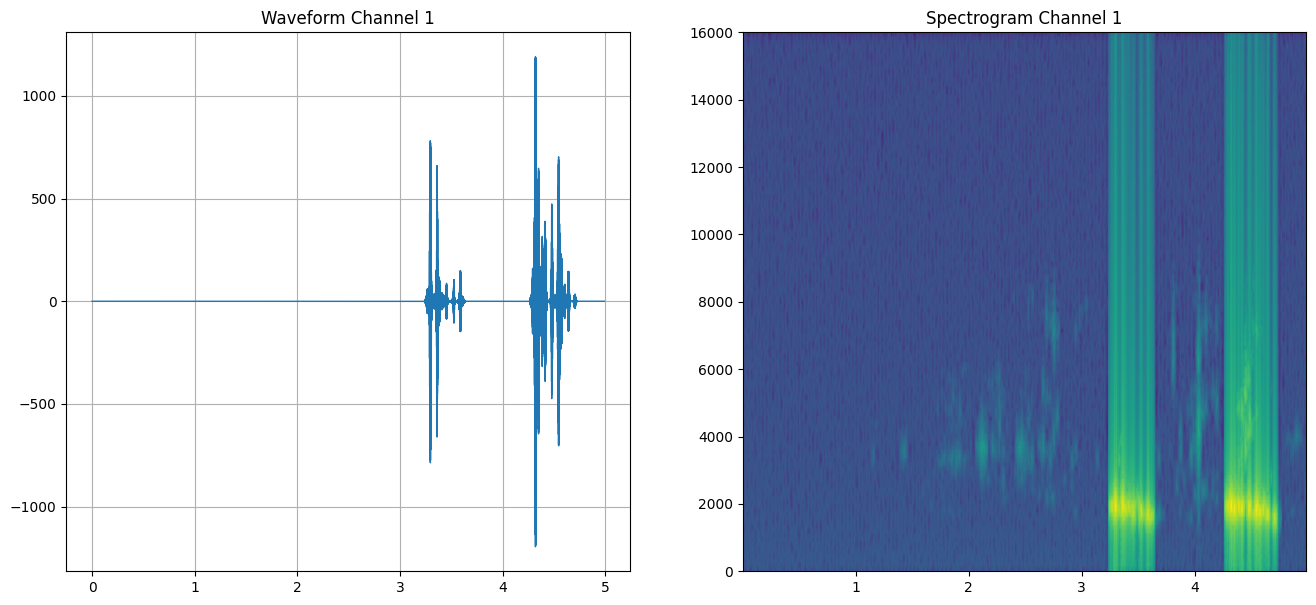

gated audio


Reconstructed audio


In [ ]:
filename = '../data/audio_data/abethr1/XC363502.ogg'
print('Original audio')
display(Audio(filename, rate=32000))
pipeline = MyPipeline()
mel_spec = pipeline(filename)
plot_spectrogram(mel_spec[0], title='Mel spectrogram', db=True)
waveform = mel_to_wave(mel_spec)
plot_audio(waveform=waveform, sample_rate=32000)
#print('Filtered audio')
#display(Audio(filtered.numpy(), rate=32000))
print('Reconstructed audio')
display(Audio(waveform.numpy(), rate=32000))


### Pytorch dataset

In [ ]:
#| export
class BirdClef(Dataset):

    def __init__(self, metadata=None, classes=None):

        self.metadata = metadata
        self.classes = classes

        self.length = len(self.metadata)

        binarizer = LabelBinarizer()
        binarizer.fit(self.classes)

        self.labels = binarizer.transform(metadata.primary_label)

        # Initialize a pipeline
        self.pipeline = MyPipeline()
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        filename = AUDIO_DATA_DIR + self.metadata['filename'][idx]
        mel_spectrogram = self.pipeline(filename)

        label = self.labels[idx]
        label = torch.from_numpy(label).float()

        return {'input': mel_spectrogram, 'label': label, 'filename': filename}

In [ ]:
train = pd.read_csv(DATA_DIR + 'base/train_metadata.csv')
ds_test = BirdClef(train, train.primary_label)
print(f'The dataset has length {len(ds_test)}')
print(f'This is an example from the dataset:\n{ds_test.__getitem__(0)}')

The dataset has length 9903
This is an example from the dataset:
(tensor([[[ -61.8296,  -67.7837, -100.0000,  ...,  -91.1590,  -37.1385,
           -31.1706],
         [ -62.5632,  -68.5024, -100.0000,  ...,  -73.5865,  -37.0465,
           -31.0355],
         [ -63.5269,  -69.4428, -100.0000,  ...,  -65.9126,  -36.5345,
           -30.3688],
         ...,
         [ -57.2081,  -56.8708,  -54.4237,  ...,  -15.5402,  -24.4950,
           -32.2047],
         [ -54.5779,  -54.0172,  -52.3218,  ...,  -15.4956,  -22.7058,
           -24.3939],
         [ -54.2062,  -53.3511,  -53.1928,  ...,  -20.4245,  -23.6496,
           -19.7236]]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

## Handling datasets and dataloaders

After creating the `BirdClef` dataset it is possible to handle the different versions (*train, val, test...*) of the dataset using a dictionary and a getter function. Since pytorch trains models using dataloaders we also need to create a method to retrieve them.

In [ ]:
#| export
dir = DATA_DIR
try:
    train_metadata_base = pd.read_csv(dir + 'base/train_metadata.csv')
    val_metadata_base = pd.read_csv(dir + 'base/val_metadata.csv')
    test_metadata_base = pd.read_csv(dir + 'base/test_metadata.csv')
except FileNotFoundError:
    dir = 'data/'
    train_metadata_base = pd.read_csv(dir + 'base/train_metadata.csv')
    val_metadata_base = pd.read_csv(dir + 'base/val_metadata.csv')
    test_metadata_base = pd.read_csv(dir + 'base/test_metadata.csv')

simple_classes = ['thrnig1', 'wlwwar', 'barswa']
train_metadata_simple = train_metadata_base.loc[train_metadata_base.primary_label.isin(simple_classes)].reset_index()
val_metadata_simple = val_metadata_base.loc[val_metadata_base.primary_label.isin(simple_classes)].reset_index()
test_metadata_simple = test_metadata_base.loc[test_metadata_base.primary_label.isin(simple_classes)].reset_index()

In [ ]:
#| export
dataset_dict = {
            'train_base': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label}),
            'val_base': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label}),
            'test_base': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label}),

            'train_simple': (BirdClef, {'metadata': train_metadata_simple, 'classes': train_metadata_simple.primary_label}),
            'val_simple': (BirdClef, {'metadata': val_metadata_simple, 'classes': train_metadata_simple.primary_label}),
            'test_simple': (BirdClef, {'metadata': test_metadata_simple, 'classes': train_metadata_simple.primary_label})
        }

In [ ]:
#| export
def get_dataset(dataset_key:str        # A key of the dataset dictionary
                )->Dataset:         # Pytorch dataset
    "A getter method to retrieve the wanted dataset."
    assert dataset_key in dataset_dict, f'{dataset_key} is not an existing dataset, choose one from {dataset_dict.keys()}.'
    ds_class, kwargs = dataset_dict[dataset_key]
    return ds_class(**kwargs)

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in dataset_dict.keys()]))

test_eq(len(dataset_dict.keys()), 6)

The existing keys are:
train_base
val_base
test_base
train_simple
val_simple
test_simple


Add example of getting a simple dataset

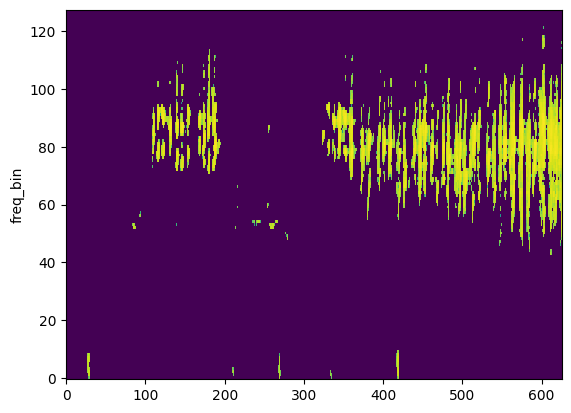

In [ ]:
ds = get_dataset('train_simple')
ds.metadata
data = ds.__getitem__(0)
mel = data['input']
plot_spectrogram(mel[0])

In [ ]:
#| export
def get_dataloader(dataset_key:str,            # The key to access the dataset
                dataloader_kwargs:dict={}      # The optional parameters for a pytorch dataloader
                )->DataLoader:              # Pytorch dataloader
    "A function to get a dataloader from a specific dataset"
    dataset = get_dataset(dataset_key)

    return DataLoader(dataset, **dataloader_kwargs)

An example of getting a dataloader

In [ ]:
#| eval:false
dl = get_dataloader('train_simple', {'batch_size': 64})
for batch in dl:
    print(batch['input'].shape)
    break

Audio too short: stretching it.


C:\Users\giach\AppData\Local\Temp\ipykernel_16076\3583216711.py:84: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:299.)
  return mel.float()


Audio too short: stretching it.
Audio too short: stretching it.
Audio too short: stretching it.
Audio too short: stretching it.
torch.Size([64, 1, 128, 626])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()